In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import matplotlib.pyplot as plt
import elk
import torch as t
import os
import pandas as pd
import numpy as np
import transformers
from transformers import AutoModelForMaskedLM, AutoTokenizer
from elk.extraction.prompt_dataset import PromptDataset, PromptConfig
from elk.extraction.extraction import ExtractionConfig, extract_hiddens, extract
import yaml
from datasets import load_dataset

from elk.utils.results import (
    RPATH,
    load_config,
    get_relevant_runs,
    get_eval,
    graph_eval,
    get_reporters,
    model_hidden_states,
    reporter_outputs,
    reporter_output,
    plot_2d_tensor_as_heatmap,
    best_layer_num,
    best_reporter,
    best_layer_output,
    dsget,
    reporter_accuracy
)

In [51]:
device = "cuda:1"
model_name = "microsoft/deberta-v2-xxlarge-mnli"
dataset_name = "ag_news"
model = AutoModelForMaskedLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name, truncation_side="left")


Some weights of the model checkpoint at microsoft/deberta-v2-xxlarge-mnli were not used when initializing DebertaV2ForMaskedLM: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing DebertaV2ForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-v2-xxlarge-mnli and are newly initialized: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
You should 

In [52]:
run_d_ag = "deberta_ag_big"
run_d_ag_ccs = "deberta_ag_ccs"
run_d_ahh = "deberta_ahh"
run_d_ahh_ccs = "deberta_ahh_ccs"

In [53]:
test_datasets = {
    "ag_news" : PromptDataset(
        PromptConfig("ag_news"),
        split="test"
    ),
    "hh" : PromptDataset(
        PromptConfig("LRudL/anthropic_hh_modified"),
        split="test"
    )
}

Found cached dataset ag_news (/fsx/home-rudolf/hf_data_cache/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|██████████| 2/2 [00:00<00:00,  9.69it/s]
Loading cached shuffled indices for dataset at /fsx/home-rudolf/hf_data_cache/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-12f3c4e4bf422cce.arrow
Found cached dataset parquet (/fsx/home-rudolf/hf_data_cache/LRudL___parquet/LRudL--anthropic_hh_modified-cd7e5952106631d3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 2/2 [00:00<00:00, 19.01it/s]
Loading cached shuffled indices for dataset at /fsx/home-rudolf/hf_data_cache/LRudL___parquet/LRudL--anthropic_hh_modified-cd7e5952106631d3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-b3a17a77de877df6.arrow


In [54]:
def get_reporter_and_layer(run):
    reporter = best_reporter(run)
    layer = best_layer_num(run)
    return reporter, layer

In [55]:
def run_accuracy(run, dataset, num_examples=100):
    """Evaluate the accuracy of the best reporter for run,
    on dataset (which may or may not be the same dataset the reporter
    was trained on)"""
    reporter, layer = get_reporter_and_layer(run)
    return reporter_accuracy(
        reporter, model, tokenizer, dataset, layer,
        num_examples=num_examples
    )

In [56]:
ag_on_ag = run_accuracy(run_d_ag, test_datasets["ag_news"])

In [57]:
ag_on_ag_ccs = run_accuracy(run_d_ag_ccs, test_datasets["ag_news"])

In [58]:
ag_on_ag

0.18466666666666667

In [59]:
ag_on_ag_ccs

0.4

In [60]:
ahh_on_ahh = run_accuracy(run_d_ahh, test_datasets["hh"])

In [61]:
ahh_on_ahh_ccs = run_accuracy(run_d_ahh_ccs, test_datasets["hh"])

In [62]:
ahh_on_ahh

0.4166666666666667

In [63]:
ahh_on_ahh_ccs

0.49

In [64]:
ahh_on_ag = run_accuracy(run_d_ahh, test_datasets["ag_news"])
ag_on_ahh = run_accuracy(run_d_ag, test_datasets["hh"])

In [65]:
ahh_on_ag

0.802

In [66]:
ag_on_ahh

0.5766666666666667

In [67]:
ahh_on_ag_ccs = run_accuracy(run_d_ahh_ccs, test_datasets["ag_news"])
ag_on_ahh_ccs = run_accuracy(run_d_ag_ccs, test_datasets["hh"])

In [50]:
ahh_on_ag_ccs

0.62

In [33]:
ag_on_ahh_ccs

0.56

# GRAPH TIME

In [68]:
import matplotlib.pyplot as plt

In [70]:
1 - ahh_on_ahh

0.5833333333333333

In [72]:
ag_on_ahh

0.5766666666666667

In [73]:
ahh_on_ag

0.802

In [75]:
1 - ag_on_ag

0.8153333333333334

Text(0.5, 1.0, 'Generalisation between datasets')

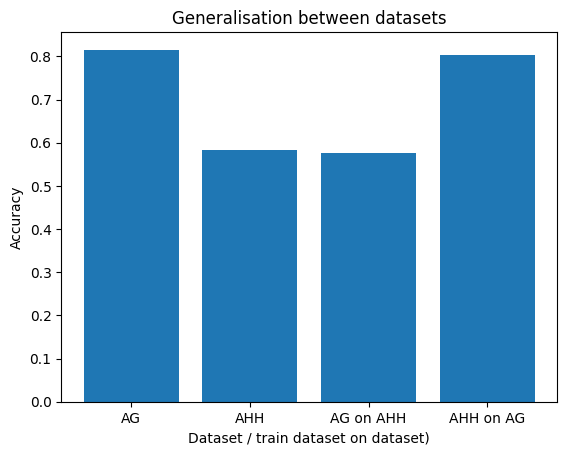

In [77]:
plt.bar(
    ["AG", "AHH", "AG on AHH", "AHH on AG"],
    [1 - ag_on_ag, 1 - ahh_on_ahh, ag_on_ahh, ahh_on_ag]
)
plt.ylabel("Accuracy")
plt.xlabel("Dataset / train dataset on dataset)")
plt.title("Generalisation between datasets")